# 1.Setup

In [1]:
from pylab import *
%matplotlib inline
import sys
import caffe
import os
import PIL
import scipy.io as sio
import tempfile

In [2]:
nyud_root = '/home/yongyang/CVProjects/nyud'

In [3]:
weights = nyud_root+'/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

# 2.Load AlexNet and modify it to adjust the image size.

In [4]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

In [33]:
def alex_net(split, tops,is_train = True, num_classes = 27,classifier_name = 'scene_classifier'):
#     """Returns a NetSpec specifying CaffeNet, following the original proto text
#      specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""    
    n = caffe.NetSpec()
    n.data,n.label = L.Python(module='nyud_layers',
            layer='NYUDSegDataLayer', ntop=2,
            param_str=str(dict(nyud_dir=nyud_root+'/data', split=split,
                tops=tops, seed=1337)))
    param = frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6_new, n.relu6 = fc_relu(n.pool5, 4096, param=learned_param)
    if is_train: # train phase need dropout layer 
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:     # test phase no dropout
        fc7input = n.relu6
    n.fc7_new, n.relu7 = fc_relu(fc7input, 4096, param=learned_param)
    if is_train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not is_train:
        n.probs = L.Softmax(fc8)
    if n.label is not None:
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    return n.to_proto()

with open('alex_train.prototxt', 'w') as f:
    f.write(str(alex_net('train', ['color','sceneLabel'])))
with open('alex_val.prototxt', 'w') as f:
    f.write(str(alex_net('val', ['color','sceneLabel'],is_train = False)))
with open('alex_test.prototxt', 'w') as f:
    f.write(str(alex_net('test', ['color','sceneLabel'],is_train = False)))

In [6]:
caffe.set_mode_cpu()
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('solver.prototxt')

In [7]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1, 3, 425, 560)),
 ('label', (1, 1)),
 ('label_data_1_split_0', (1, 1)),
 ('label_data_1_split_1', (1, 1)),
 ('conv1', (1, 96, 104, 138)),
 ('pool1', (1, 96, 52, 69)),
 ('norm1', (1, 96, 52, 69)),
 ('conv2', (1, 256, 52, 69)),
 ('pool2', (1, 256, 26, 34)),
 ('norm2', (1, 256, 26, 34)),
 ('conv3', (1, 384, 26, 34)),
 ('conv4', (1, 384, 26, 34)),
 ('conv5', (1, 256, 26, 34)),
 ('pool5', (1, 256, 13, 17)),
 ('fc6_new', (1, 4096)),
 ('fc7_new', (1, 4096)),
 ('scene_classfier', (1, 27)),
 ('scene_classfier_scene_classfier_0_split_0', (1, 27)),
 ('scene_classfier_scene_classfier_0_split_1', (1, 27)),
 ('loss', ()),
 ('acc', ())]

In [8]:
print 'train',solver.net.forward()  # train net
print 'val',solver.test_nets[0].forward()  # test net (there can be more than one)
print 'test',solver.test_nets[1].forward()  # test net (there can be more than one)

train {'acc': array(0.0, dtype=float32), 'loss': array(3.295836925506592, dtype=float32)}
val {'acc': array(0.0, dtype=float32), 'loss': array(3.295836925506592, dtype=float32), 'probs': array([[ 0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704]], dtype=float32)}
test {'acc': array(0.0, dtype=float32), 'loss': array(3.295836925506592, dtype=float32), 'probs': array([[ 0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
         0.03703704,  0.03703704,  0.03703704,  0.03703704,  0.03703704,
      

# 3. Visualize the data

In [9]:
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [10]:
allSceneLabel =sio.loadmat('/home/yongyang/CVProjects/nyud/data/sceneLabel/imgAllScene.mat')

In [11]:
allSceneLabel.keys()

['sceneName', '__version__', 'gtScene', '__header__', '__globals__']

The scenery is  home_office


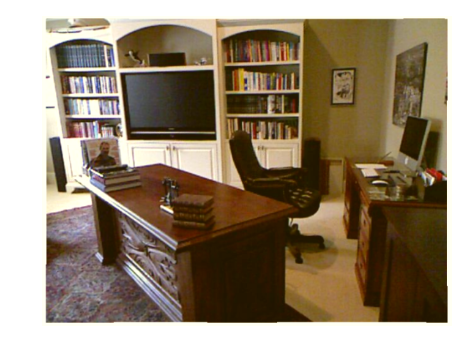

In [12]:
# Show the image here 
solver.net.forward()
imshow(deprocess_net_image(solver.net.blobs['data'].data[0])); axis('off')
index = int(solver.net.blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

The scenery is  basement


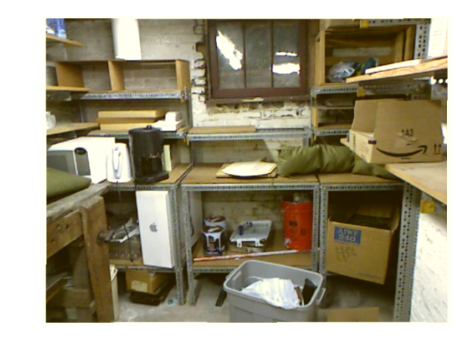

In [13]:
solver.test_nets[0].forward()
imshow(deprocess_net_image(solver.test_nets[0].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[0].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

The scenery is  bathroom


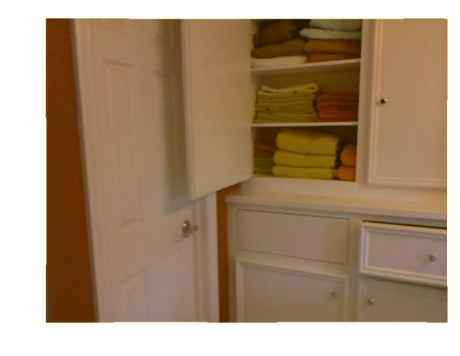

In [14]:
solver.test_nets[1].forward()
imshow(deprocess_net_image(solver.test_nets[1].blobs['data'].data[0]));axis('off')
index = int(solver.test_nets[1].blobs['label'].data[0])
print 'The scenery is ',allSceneLabel['sceneName'][0][index-1][0]

# 4. Training phase

In [15]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001,reg = 5e-4):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = reg

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = nyud_root + 'nyud-fcns-colr/alex/snapshot/train'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [37]:
def run_solver(niter,solver,disp_interval=20):
    """Run solver for niter iterations,returning loss and accuracy
    """
    loss = np.zeros(niter)
    loss_ave = zeros(int(np.ceil(niter / disp_interval)))
    for it in xrange(niter):
        solver.step(1)
        loss[it] = solver.net.blobs['loss'].data.copy()
        if it % disp_interval== 0 :
            if it!=0:
                loss_ave[it/disp_interval-1] = loss[it-disp_interval:it+1].mean()
                print 'iter %d loss is %f'%(it,loss_ave[it/disp_interval-1])
                
    train_correct = 0 
    for i in range(364): # the number in train test is 364
        solver.net.forward()
        train_correct += sum(solver.net.blobs['scene_classifier'].data.argmax(1)
               == solver.net.blobs['label'].data)
    train_acc = train_correct/364.
    print train_correct
    print 'train accuracy is %f'% train_acc  
    
    # validation phase
    correct = 0.
    for i in range(364): # the number in validation is 364
        solver.test_nets[0].forward()
        correct += sum(solver.test_nets[0].blobs['probs'].data.argmax(1)
               == solver.test_nets[0].blobs['label'].data)
    val_acc = correct/364.
    print correct
    print 'accuracy is %f'% val_acc
    return loss,loss_ave,val_acc

In [38]:
from caffe.proto import caffe_pb2
from google.protobuf import text_format
solver_config = caffe_pb2.SolverParameter()
with open('/home/yongyang/CVProjects/nyud/nyud-color/alex/solver.prototxt') as f:
    text_format.Merge(str(f.read()), solver_config)

In [39]:
# Modify solver parameters here
solver_config.base_lr = 3e-5
solver_config.weight_decay = 3e-1
solver_config.iter_size = 20
solver_config.snapshot = 6000

solver_config.lr_policy = 'step'
solver_config.gamma = 0.1
solver_config.stepsize = 3000
# write to file
new_solver_config = text_format.MessageToString(solver_config)
with open('temp.prototxt', 'w') as f:
    f.write(new_solver_config) 

In [40]:
# load weights from pretrained model
solver = caffe.SGDSolver('temp.prototxt')
solver.net.copy_from(weights)

In [41]:
%%time
num_epoch = 1
niter = 734
print 'Running solvers for %d epoches...' % num_epoch
for i in range(num_epoch):
    print 'Running solvers in %d epoch:' % (i+1)
    train_loss, loss_ave, val_acc = run_solver(niter, solver)
print 'Done.'

Running solvers for 1 epoches...
Running solvers in 1 epoch:
iter 20 loss is 2.530511
iter 40 loss is 6.162324
iter 60 loss is 1.957217
iter 80 loss is 2.450515
iter 100 loss is 2.430143
iter 120 loss is 6.569971
iter 140 loss is 2.218809
iter 160 loss is 2.078340
iter 180 loss is 1.956869
iter 200 loss is 1.918896
iter 220 loss is 5.625552
iter 240 loss is 1.934005
iter 260 loss is 1.670079
iter 280 loss is 2.084962
iter 300 loss is 2.112269
iter 320 loss is 2.110175
iter 340 loss is 1.600631
iter 360 loss is 1.784741
iter 380 loss is 1.422366
iter 400 loss is 1.424294
iter 420 loss is 1.790174
iter 440 loss is 1.732928
iter 460 loss is 1.460928
iter 480 loss is 1.145022
iter 500 loss is 1.046493
iter 520 loss is 1.245512
iter 540 loss is 1.535414
iter 560 loss is 1.446766
iter 580 loss is 4.933396
iter 600 loss is 1.093488
iter 620 loss is 1.149318
iter 640 loss is 1.009049
iter 660 loss is 0.657076
iter 680 loss is 5.328303
iter 700 loss is 1.077256
iter 720 loss is 5.215895
308
tra

In [32]:
train_correct = 0 
for i in range(414): # the number in validation is 414
    solver.net.forward()
    train_correct += sum(solver.net.blobs['scene_classfier'].data.argmax(1)
           == solver.net.blobs['label'].data)
train_acc = train_correct/414.
print train_correct
print 'train accuracy is %f'% train_acc  

# validation phase
correct = 0.
for i in range(364): # the number in validation is 364
    solver.test_nets[0].forward()
    correct += sum(solver.test_nets[0].blobs['probs'].data.argmax(1)
           == solver.test_nets[0].blobs['label'].data)
val_acc = correct/364.
print correct
print 'accuracy is %f'% val_acc

290
train accuracy is 0.700483
143.0
accuracy is 0.392857


In [37]:
# solver.snapshot()

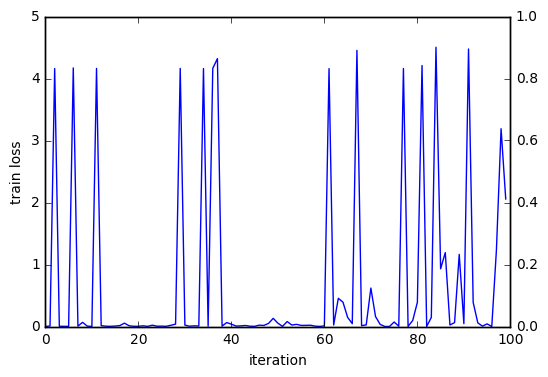

In [10]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(loss_ave)
#ax2.plot(test_interval* arange(len(val_acc)), val_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
#ax2.set_ylabel('validation accuracy')
#ax2.set_title('validation Accuracy: {:.2f}'.format(val_acc[-1]))

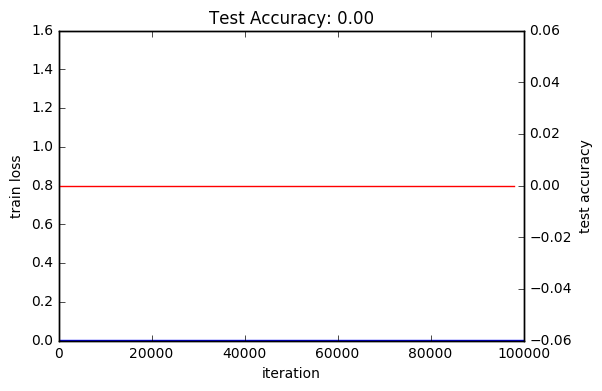

In [77]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
print test_acc[-1]

In [ ]:
solver.snapshot()

# Test phase

In [27]:
caffe.set_mode_cpu()
solver = caffe.SGDSolver('temp.prototxt')
solver.restore('snapshot/train_iter_2000.solverstate')
solver.test_nets[0].share_with(solver.net)
solver.test_nets[1].share_with(solver.net)

In [11]:
%%time
niter = 351
output = zeros((niter, 1, 27))
ground_truth = zeros((niter,1,1))
correct = 0
# the main solver loop
print 'testing...'
for it in range(niter):
    # store the output on the first test batch
    # (start the forward pass at conv1
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
#  how to do it directly in Python, where more complicated things are easi
    
    solver.test_nets[1].forward()
    output[it] = solver.test_nets[1].blobs['probs'].data
    ground_truth[it] = solver.test_nets[1].blobs['label'].data
    correct += sum(solver.test_nets[1].blobs['probs'].data.argmax(1)
                   == solver.test_nets[1].blobs['label'].data)
test_acc = correct / 351.
print 'num_correct %d'%correct
print 'test accuracy: %f'%test_acc                                                                                                                         

testing...
num_correct 130
test accuracy: 0.370370
CPU times: user 2min 11s, sys: 712 ms, total: 2min 11s
Wall time: 1min 5s


In [17]:
output.shape

(654, 1, 27)

In [67]:
ground_truth[9][0][0]

3.0

In [42]:
import pandas as pd

In [43]:
tran_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/train.txt',header = None)
val_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/val.txt',header = None)
test_txt = pd.read_csv('/home/yongyang/CVProjects/nyud/data/test.txt',header = None)

In [41]:
print len(tran_txt)
print len(val_txt)
print len(test_txt)

381
414
654


# Calculate the accuracy for all kinds of scenerys independently

In [44]:
scenes_lists = []
for i in xrange(27):
    scenes_lists.append([])
for i in xrange(ground_truth.shape[0]):
    scenes_lists[int(ground_truth[i][0][0])-1].append(i)

In [45]:
result = np.zeros((27,2))
for i in xrange(27):
    num = len(scenes_lists[i])
    accu = nan
    correct = 0.
    if num!=0:
        for j in range(num):
            correct += sum(output[j].argmax(1) == ground_truth[j])
        accu = correct/num
    result[i][0] = num
    result[i][1] = accu

In [46]:
result_pd = pd.DataFrame(result)
result_pd['scene_name'] = 'ok'
for i in xrange(27):
    result_pd['scene_name'][i]= allSceneLabel['sceneName'][0][i][0]
result_pd.columns = ['num','accuracy','scene_name']
result_pd = result_pd.set_index('scene_name',drop = True)
result_pd['num'] = result_pd['num'].astype('int')
result_pd.to_csv('test_result.csv')

/home/yongyang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
print result_pd[0:5]

            num  accuracy
scene_name               
basement      1  1.000000
bathroom     30  0.433333
bedroom      95  0.326316
bookstore     9  0.555556
cafe          1  1.000000


In [109]:
allSceneLabel['sceneName'][0][2:4]

array([array([u'bedroom'], 
      dtype='<U7'),
       array([u'bookstore'], 
      dtype='<U9')], dtype=object)